<a href="https://colab.research.google.com/github/najouaelfethi/bigdataproject/blob/main/EDA_Pr%C3%A9traitement%26Mod%C3%A9lisation_Pr%C3%A9dective_Consommation_%C3%A9nergitique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prédire la consommation énergitique future (Analyse en séries temporelles)

## EDA (Exploratory Data Analysis)
**Objectif :** se mettre à l’aise avec le dataset et comprendre au maximum nos différentes variables pour ensuite définir une stratégie de modélisation. Qu’est-ce qu’on va faire avec nos données pour atteindre notre objectif ?
Checklist de base (Non-exhaustive) :

**Analyse de la forme :**
- **Identification de la Target :**
    - AEP_MW (consommation de l'énergie électrique en MégaWT)
- **Nombre de lignes et de colonnes :**(121273 Lignes, 2 Colonnes)
- **Types de variables :**
    - 1 Quantitative / Continue(AEP_MW)
    - 1 Qualitative / Variable temporelle (Datetime)
- **Analyse des valeurs manquantes :**
    - 0 valeurs manquantes trouvé.

**Analyse du fond :**
- **Visualisation de la Target :**
    - En déchiffrant la variable AWP_MW pour différent référence temporelle, nous obtenons qu'il y a certain année notamment **2004** et **2018** qui ne possèdent pas de valeurs de consommation pour certain mois.
    - Après une étude approfondie, nous avons conclu que ce sont les successivement les années de début et de fin de l'opération de collection des données de consommation énergitique.
- **Compréhension des différentes variables (Internet) :**
    - **Saisonalité -**
    - pendant les mois d'Hiver la consommation atteint ses pics notamment les mois 12-1-2, cela peut etre expliqué par le fait d'utilisation des chauffages. Ainsi que pendant l'été pour les climatiseurs.
    - En printemps et en automne, généralement ce sont des saisons stable en consommation, les moyennes de consommation sont plus faibles 3-4-5

    - **Mensualité -**
    - Apparemment que l'année 2007 préconise le pic de consommation, cela peut etre signifié par une crise énergitique mais cela reste qu'une hypothèse (à vérifier plus tard).
    - 2008 aussi reste importante en terme de consommation par rapport au autres distributions.
    - **Données Anuelle -**
    - la consommation depuis 2005 jusqu'à 2010 atteint ces pics, cepandant après 2010 la consommation continue à diminuer d'une façon plus vite.
    - Cela probablement est du à l'exploration de nouveaux sources d'enérgies remplacante, tels que les énergies renouvelables (solaire, éoliène, etc) ainsi que l'adoption de technologies plus économes en énergie dans les secteurs résidentiel, industriel et commercial.
    - **Données journalières -** ils sont apperement continues et ne contiennent pas de doublons.


- **Visualisation des relations Features – Target (Histogrammes/Boxplot) :**

- **Identification des outliers :**
    - Valeurs aberrantes détectées :  11



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Datasets/AEP_hourly.csv")

In [ ]:
data.head(25)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
5,2004-12-31 06:00:00,13038.0
6,2004-12-31 07:00:00,13692.0
7,2004-12-31 08:00:00,14297.0
8,2004-12-31 09:00:00,14719.0
9,2004-12-31 10:00:00,14941.0


In [ ]:
data.shape

(121273, 2)

In [ ]:
data.dtypes

,0
Datetime,object
AEP_MW,float64


# Visualisation des valeurs manquantes(NaN)

<Axes: >

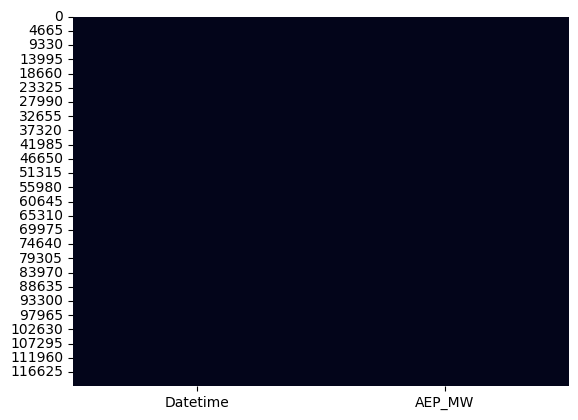

In [ ]:
sns.heatmap(data.isna(), cbar=False)

# Distribution de la consommation

<ipython-input-8-901936e95bfd>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['AEP_MW'],shade=True, color="blue")


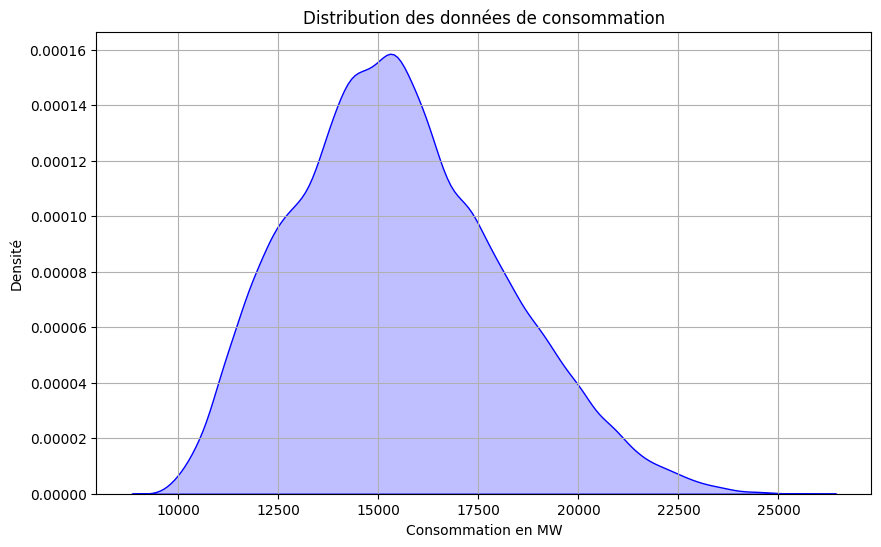

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(data['AEP_MW'],shade=True, color="blue")
plt.title('Distribution des données de consommation')
plt.xlabel('Consommation en MW')
plt.ylabel('Densité')
plt.grid()
plt.show()



```
# This is formatted as code
```

- les données de consommation suivent une distribution normale cela signifie qu'il n y a pas d'agitation démarquante dans nos données

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, year, month, avg, sum, to_date,col

In [6]:
spark = SparkSession.builder.appName("EnergyConsumptionApp").getOrCreate()

In [7]:
df = spark.read.csv("/content/drive/MyDrive/Datasets/AEP_hourly.csv", header=True, inferSchema=True)

df.printSchema()

df = df.withColumn("Datetime", to_timestamp(df["Datetime"]))

root
 |-- Datetime: timestamp (nullable = true)
 |-- AEP_MW: double (nullable = true)



In [8]:
df.show()

+-------------------+-------+
|           Datetime| AEP_MW|
+-------------------+-------+
|2004-12-31 01:00:00|13478.0|
|2004-12-31 02:00:00|12865.0|
|2004-12-31 03:00:00|12577.0|
|2004-12-31 04:00:00|12517.0|
|2004-12-31 05:00:00|12670.0|
|2004-12-31 06:00:00|13038.0|
|2004-12-31 07:00:00|13692.0|
|2004-12-31 08:00:00|14297.0|
|2004-12-31 09:00:00|14719.0|
|2004-12-31 10:00:00|14941.0|
|2004-12-31 11:00:00|15184.0|
|2004-12-31 12:00:00|15009.0|
|2004-12-31 13:00:00|14808.0|
|2004-12-31 14:00:00|14522.0|
|2004-12-31 15:00:00|14349.0|
|2004-12-31 16:00:00|14107.0|
|2004-12-31 17:00:00|14410.0|
|2004-12-31 18:00:00|15174.0|
|2004-12-31 19:00:00|15261.0|
|2004-12-31 20:00:00|14774.0|
+-------------------+-------+
only showing top 20 rows



#Extraction des variables Year & Month


In [9]:
df = df.withColumn("Year", year(df["Datetime"]))
df = df.withColumn("Month", month(df["Datetime"]))

In [10]:
df.show()

+-------------------+-------+----+-----+
|           Datetime| AEP_MW|Year|Month|
+-------------------+-------+----+-----+
|2004-12-31 01:00:00|13478.0|2004|   12|
|2004-12-31 02:00:00|12865.0|2004|   12|
|2004-12-31 03:00:00|12577.0|2004|   12|
|2004-12-31 04:00:00|12517.0|2004|   12|
|2004-12-31 05:00:00|12670.0|2004|   12|
|2004-12-31 06:00:00|13038.0|2004|   12|
|2004-12-31 07:00:00|13692.0|2004|   12|
|2004-12-31 08:00:00|14297.0|2004|   12|
|2004-12-31 09:00:00|14719.0|2004|   12|
|2004-12-31 10:00:00|14941.0|2004|   12|
|2004-12-31 11:00:00|15184.0|2004|   12|
|2004-12-31 12:00:00|15009.0|2004|   12|
|2004-12-31 13:00:00|14808.0|2004|   12|
|2004-12-31 14:00:00|14522.0|2004|   12|
|2004-12-31 15:00:00|14349.0|2004|   12|
|2004-12-31 16:00:00|14107.0|2004|   12|
|2004-12-31 17:00:00|14410.0|2004|   12|
|2004-12-31 18:00:00|15174.0|2004|   12|
|2004-12-31 19:00:00|15261.0|2004|   12|
|2004-12-31 20:00:00|14774.0|2004|   12|
+-------------------+-------+----+-----+
only showing top

# Visulaisation de la consommation moyenne par année

In [11]:
# Calculer la consommation moyenne par année
annual_avg_consumption = df.groupBy("Year").agg(avg("AEP_MW").alias("average_consumption"))

# Transformation en Pandas dataframe
pd_annual_avg_consumption = annual_avg_consumption.toPandas()

# Sauvegarde des résultats
pd_annual_avg_consumption.to_excel("/content/drive/MyDrive/Datasets/result_data/AVG_annee.xlsx",index=False)

# Afficher les résultats
annual_avg_consumption.show()

+----+-------------------+
|Year|average_consumption|
+----+-------------------+
|2007|  16645.51929664307|
|2018| 15290.612733644859|
|2015| 14868.922602739725|
|2006| 15737.224252112355|
|2013| 15198.211577985841|
|2014|  15169.07889028428|
|2004| 15176.724388032639|
|2012|  15352.94066734996|
|2009| 15254.111669330898|
|2016| 14784.225979052824|
|2005| 15842.990865494405|
|2010| 16008.619504396484|
|2011| 15815.389472482302|
|2008|  16536.65565930312|
|2017| 14483.738356164384|
+----+-------------------+



In [12]:
# Filtrage des années en ordre
pd_annual_avg_consumption = pd_annual_avg_consumption.sort_values('Year')

# Affichage du dataframe
pd_annual_avg_consumption

,Year,average_consumption
6,2004,15176.724388
10,2005,15842.990865
3,2006,15737.224252
0,2007,16645.519297
13,2008,16536.655659
8,2009,15254.111669
11,2010,16008.619504
12,2011,15815.389472
7,2012,15352.940667
4,2013,15198.211578


#Visualisation de la consommation annuelle


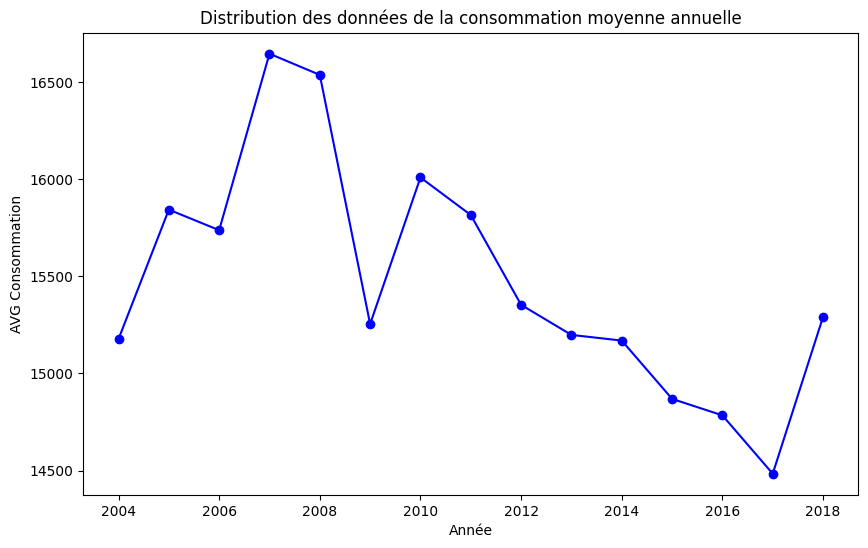

In [13]:
plt.figure(figsize=(10,6))
plt.plot(pd_annual_avg_consumption['Year'],pd_annual_avg_consumption['average_consumption'], marker='o', color="blue")
plt.title('Distribution des données de la consommation moyenne annuelle')
plt.xlabel('Année')
plt.ylabel('AVG Consommation')
plt.show()

- la consommation depuis 2005 jusqu'à 2010 atteint ces pics, cepandant après 2010 la consommation continue à diminuer d'une façon plus vite.
- Cela probablement est du à l'exploration de nouveaux sources d'enérgies remplacante, tels que les énergies renouvelables (solaire, éoliène, etc) ainsi que l'adoption de technologies plus économes en énergie dans les secteurs résidentiel, industriel et commercial.

# Visualisation de la consommation mensuelle pour chaque année

In [14]:
# Agréger les données par année et mois
df_monthly_consumption = df.groupBy("Year", "Month") \
    .agg(
        sum("AEP_MW").alias("total_consumption"),  # Somme de la consommation
        avg("AEP_MW").alias("avg_consumption")  # Moyenne de la consommation
    ) \
    .orderBy("Year","Month")  # Trier par année et mois

# Afficher le résultat
df_monthly_consumption.show()


+----+-----+-----------------+------------------+
|Year|Month|total_consumption|   avg_consumption|
+----+-----+-----------------+------------------+
|2004|   10|      1.0349073E7|13947.537735849057|
|2004|   11|      1.0677917E7|14830.440277777778|
|2004|   12|      1.2452864E7|16737.720430107525|
|2005|    1|      1.2735114E7| 17117.08870967742|
|2005|    2|      1.1085745E7|16496.644345238095|
|2005|    3|      1.1847502E7| 15924.06182795699|
|2005|    4|      1.0089312E7| 14032.42280945758|
|2005|    5|      1.0181694E7|13685.072580645161|
|2005|    6|       1.170024E7|16250.333333333334|
|2005|    7|      1.2546722E7| 16863.87365591398|
|2005|    8|      1.2834811E7| 17251.09005376344|
|2005|    9|      1.1049942E7|15347.141666666666|
|2005|   10|      1.0685367E7|14381.382234185734|
|2005|   11|      1.0940315E7|15194.881944444445|
|2005|   12|       1.305615E7| 17548.58870967742|
|2006|    1|      1.2208918E7|16409.836021505376|
|2006|    2|      1.1569171E7|17216.028273809523|


# Années incomplètes au niveau des mois

In [15]:
df_monthly_consumption.filter(df_monthly_consumption['Year']==2004).show()

+----+-----+-----------------+------------------+
|Year|Month|total_consumption|   avg_consumption|
+----+-----+-----------------+------------------+
|2004|   10|      1.0349073E7|13947.537735849057|
|2004|   11|      1.0677917E7|14830.440277777778|
|2004|   12|      1.2452864E7|16737.720430107525|
+----+-----+-----------------+------------------+



In [16]:
df_monthly_consumption.filter(df_monthly_consumption['Year']==2018).show()

+----+-----+-----------------+------------------+
|Year|Month|total_consumption|   avg_consumption|
+----+-----+-----------------+------------------+
|2018|    1|      1.3090587E7|         17594.875|
|2018|    2|      1.0265918E7| 15276.66369047619|
|2018|    3|      1.1228646E7|15112.578734858682|
|2018|    4|        9820256.0|13639.244444444445|
|2018|    5|      1.0503052E7|14117.005376344086|
|2018|    6|       1.101978E7|          15305.25|
|2018|    7|      1.1849407E7|15926.622311827958|
|2018|    8|         754941.0|15406.959183673469|
+----+-----+-----------------+------------------+



- 2004 ne possède que trois mois 10,11,12

- 2018 ne possède que entre 1-8



# Décision immédiate
- On a décidé d'éliminer ces deux année (2004 & 2018) bien que cela concerne la phase prétraitement

In [17]:
# Elimination des année non complètes en termes de mois
df = df.filter((df_monthly_consumption['Year']!=2004) & (df_monthly_consumption['Year']!=2018))

df_monthly_consumption = df_monthly_consumption.filter((df_monthly_consumption['Year']!=2004) & (df_monthly_consumption['Year']!=2018))

In [18]:
# Transformation en Pandas dataframe
pd_monthly_consumption = df_monthly_consumption.orderBy("Year", "Month").toPandas()

# Sauvegarde des résultats
pd_monthly_consumption.to_excel("/content/drive/MyDrive/Datasets/result_data/Consommation_mensuelle_par_annee.xlsx",index=False)

In [19]:
pd_monthly_consumption

,Year,Month,total_consumption,avg_consumption
0,2005,1,12735114.0,17117.088710
1,2005,2,11085745.0,16496.644345
2,2005,3,11847502.0,15924.061828
3,2005,4,10089312.0,14032.422809
4,2005,5,10181694.0,13685.072581
...,...,...,...,...
151,2017,8,11190134.0,15040.502688
152,2017,9,9945277.0,13812.884722
153,2017,10,9921554.0,13335.422043
154,2017,11,10305415.0,14293.224688


# Visualisation de la consommation mensuelle pour chaque année du Dataset

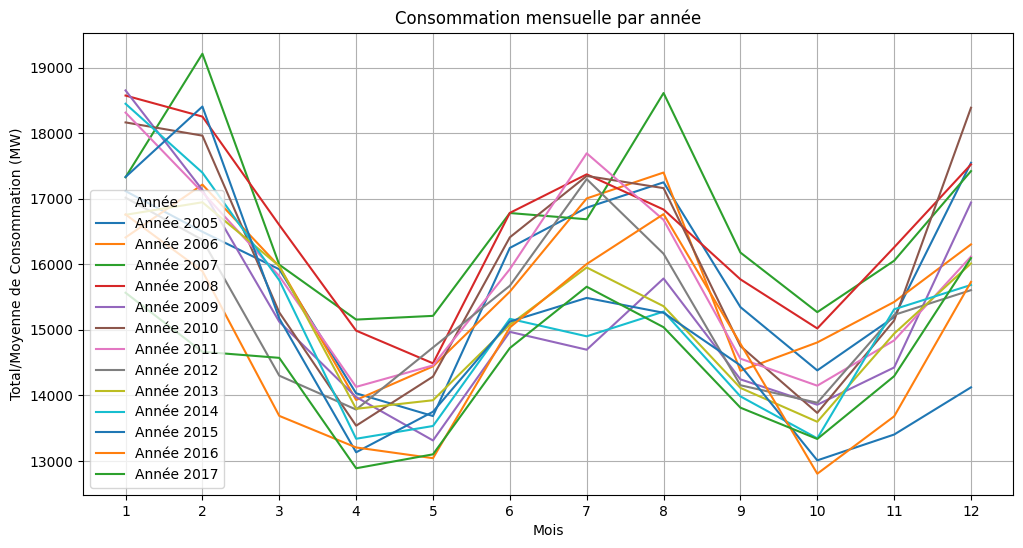

In [20]:
# Préparer les données pour le tracé
years = pd_monthly_consumption['Year'].unique()  # Liste des années disponibles

plt.figure(figsize=(12, 6))

# Boucle pour tracer une courbe par année
for year in years:
    # Filtrer les données pour une année donnée
    data_year = pd_monthly_consumption[pd_monthly_consumption['Year'] == year]
    # Tracer les données pour cette année
    plt.plot(
        data_year['Month'],
        data_year['avg_consumption'],  # Remplacez par 'avg_consumption' si nécessaire
        #marker='o',
        label=f"Année {year}"
    )

# Ajouter des labels et une légende
plt.title('Consommation mensuelle par année')
plt.xlabel('Mois')
plt.ylabel('Total/Moyenne de Consommation (MW)')
plt.xticks(range(1, 13))  # Afficher les mois de 1 à 12
plt.legend(title="Année")
plt.grid(True)
plt.show()


##Résultat & explications
- Apparemment que l'année 2007 préconise le pic de consommation, cela peut etre signifié par une crise énergitique mais cela reste qu'une hypothèse (à vérifier plus tard).
- 2008 aussi reste importante en terme de consommation par rapport au autres distributions.

# Visualisation de la consommation globale par saisons (Hiver, Printemps, été, Automne)

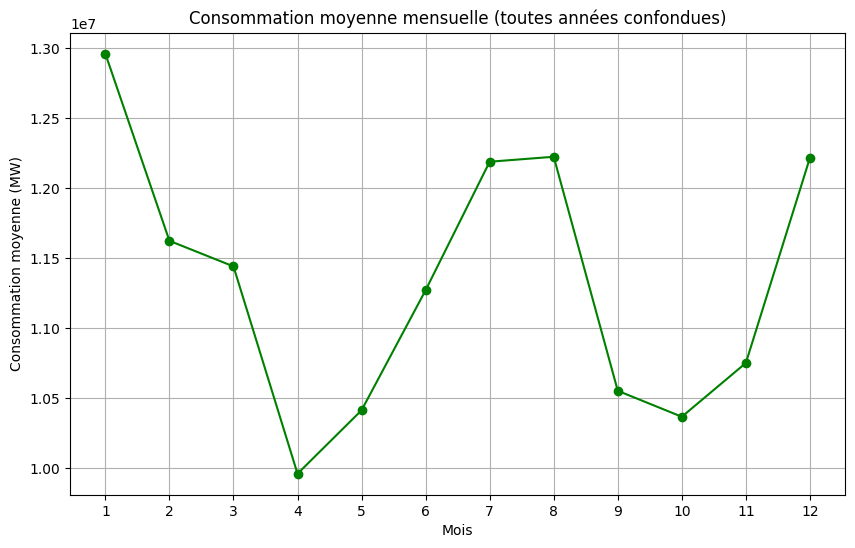

In [21]:
df_monthly_avg = df_monthly_consumption.groupBy("Month") \
    .agg(avg("total_consumption").alias("avg_monthly_consumption")) \
    .orderBy("Month").toPandas()

plt.figure(figsize=(10, 6))
plt.plot(df_monthly_avg['Month'], df_monthly_avg['avg_monthly_consumption'], marker='o', color='green')
plt.title('Consommation moyenne mensuelle (toutes années confondues)')
plt.xlabel('Mois')
plt.ylabel('Consommation moyenne (MW)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


- pendant les mois d'Hiver la consommation atteint ses pics notamment les mois 12-1-2, cela peut etre expliqué par le fait d'utilisation des chauffages. Ainsi que pendant l'été pour les climatiseurs.

- En printemps et en automne, généralement ce sont des saisons stable en consommation, les moyennes de consommation sont plus faibles 3-4-5

# Consommation journalière

In [22]:
#df_without_04_18 = df.filter((df_monthly_consumption['Year']!=2004) & (df_monthly_consumption['Year']!=2018))

df_daily_consumption = df.withColumn("Date", to_date("Datetime"))

df_daily_sum = df_daily_consumption.groupBy("Date").agg(sum("AEP_MW").alias("Daily_Total_Consumption"))

pd_daily_sum = df_daily_sum.orderBy("Date").toPandas()


df_daily_sum.show()


+----------+-----------------------+
|      Date|Daily_Total_Consumption|
+----------+-----------------------+
|2005-06-06|               415076.0|
|2005-01-16|               400928.0|
|2006-05-21|               299369.0|
|2006-05-17|               350074.0|
|2007-11-23|               364940.0|
|2007-11-15|               405689.0|
|2007-04-20|               360528.0|
|2009-11-22|               336695.0|
|2009-07-25|               329883.0|
|2010-08-11|               463118.0|
|2012-10-06|               294810.0|
|2012-04-17|               336136.0|
|2013-09-09|               395840.0|
|2013-05-21|               392858.0|
|2013-03-26|               412198.0|
|2013-01-22|               487307.0|
|2014-11-12|               361410.0|
|2014-09-26|               331291.0|
|2015-05-19|               342909.0|
|2015-03-09|               361881.0|
+----------+-----------------------+
only showing top 20 rows



In [23]:
# Sauvegarde des résultats
pd_daily_sum.to_excel("/content/drive/MyDrive/Datasets/result_data/daily_data.xlsx",index=False)
pd_daily_sum

,Date,Daily_Total_Consumption
0,2005-01-01,311897.0
1,2005-01-02,322712.0
2,2005-01-03,363937.0
3,2005-01-04,374003.0
4,2005-01-05,389445.0
...,...,...
4743,2017-12-27,439663.0
4744,2017-12-28,465511.0
4745,2017-12-29,434221.0
4746,2017-12-30,414764.0


# Vérification des doublons

In [24]:
from pyspark.sql.functions import count

# Groupement par date et comptage
duplicates = df_daily_sum.groupBy("Date").agg(count("*").alias("count"))

# Filtrer les dates ayant plus d'une occurrence
duplicates = duplicates.filter(col("count") > 1)

# Afficher les doublons
duplicates.show()


+----+-----+
|Date|count|
+----+-----+
+----+-----+



#Vérification des outliers

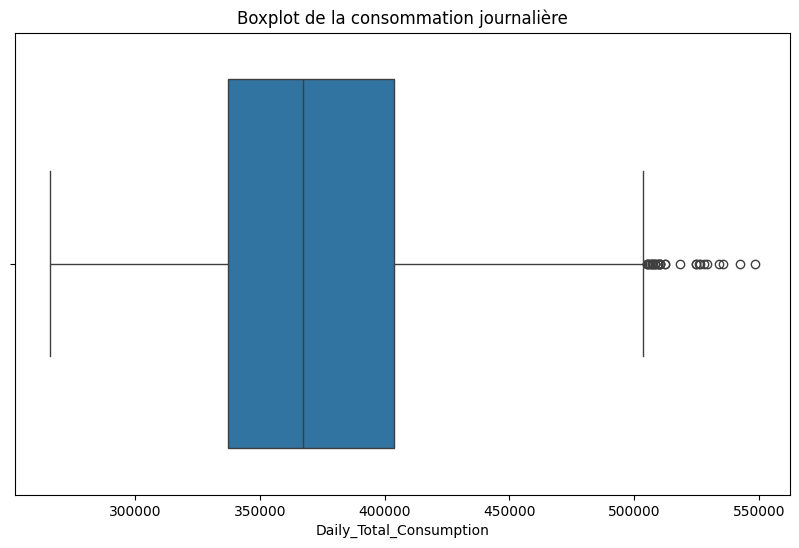

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=pd_daily_sum["Daily_Total_Consumption"])
plt.title("Boxplot de la consommation journalière")
plt.show()

In [26]:
from scipy.stats import zscore


pd_daily_sum["z_score"] = zscore(pd_daily_sum["Daily_Total_Consumption"])
outliers = pd_daily_sum[pd_daily_sum["z_score"].abs() > 3]
print("Valeurs aberrantes détectées : ", len(outliers))


Valeurs aberrantes détectées :  11


In [27]:
outliers

,Date,Daily_Total_Consumption,z_score
765,2007-02-05,526420.0,3.241733
766,2007-02-06,542682.0,3.583775
1476,2009-01-16,548349.0,3.702971
2173,2010-12-14,518482.0,3.074771
3293,2014-01-07,535660.0,3.436080
3310,2014-01-24,528058.0,3.276185
3314,2014-01-28,525861.0,3.229975
3315,2014-01-29,524931.0,3.210414
3659,2015-01-08,524960.0,3.211024
3701,2015-02-19,533988.0,3.400912


In [28]:
import numpy as np

np_outliers= outliers["Daily_Total_Consumption"].to_numpy()
np_outliers

array([526420., 542682., 548349., 518482., 535660., 528058., 525861.,
       524931., 524960., 533988., 529129.])

#Prétraitement des données (Features Engineering, Encodage, Standardisation, etc)
- **Objectif :** Préparation de nos données en format plus propice pour que notre modèle réussi à bien prévoire la consommation future
  

#Vérification de la linéarité des données

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)


                              OLS Regression Results                              
Dep. Variable:     avg_annual_consumption   R-squared:                       0.653
Model:                                OLS   Adj. R-squared:                  0.621
Method:                     Least Squares   F-statistic:                     20.70
Date:                    Wed, 25 Dec 2024   Prob (F-statistic):           0.000831
Time:                            14:32:39   Log-Likelihood:                -181.05
No. Observations:                      13   AIC:                             366.1
Df Residuals:                          11   BIC:                             367.2
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

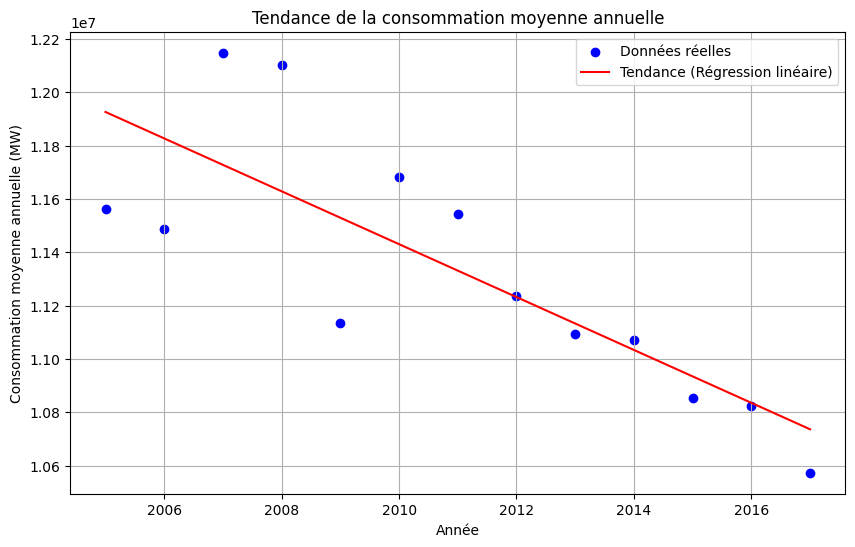

In [29]:
import statsmodels.api as sm

df_annual = df_monthly_consumption.groupBy("Year") \
    .agg(avg("total_consumption").alias("avg_annual_consumption")) \
    .orderBy("Year").toPandas()

X = df_annual['Year']
y = df_annual['avg_annual_consumption']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

# Tracé
plt.figure(figsize=(10, 6))
plt.scatter(df_annual['Year'], df_annual['avg_annual_consumption'], color='blue', label='Données réelles')
plt.plot(df_annual['Year'], model.predict(X), color='red', label='Tendance (Régression linéaire)')
plt.title('Tendance de la consommation moyenne annuelle')
plt.xlabel('Année')
plt.ylabel('Consommation moyenne annuelle (MW)')
plt.legend()
plt.grid(True)
plt.show()


###importation des données journalières

In [30]:
#df1 = pd.read_excel("/content/drive/MyDrive/Datasets/result_data/daily_data.xlsx")
df1 = df_daily_sum.orderBy(col("Date").asc())
df1.show()

+----------+-----------------------+
|      Date|Daily_Total_Consumption|
+----------+-----------------------+
|2005-01-01|               311897.0|
|2005-01-02|               322712.0|
|2005-01-03|               363937.0|
|2005-01-04|               374003.0|
|2005-01-05|               389445.0|
|2005-01-06|               374851.0|
|2005-01-07|               389679.0|
|2005-01-08|               363338.0|
|2005-01-09|               349828.0|
|2005-01-10|               390332.0|
|2005-01-11|               394250.0|
|2005-01-12|               368065.0|
|2005-01-13|               360620.0|
|2005-01-14|               400007.0|
|2005-01-15|               397533.0|
|2005-01-16|               400928.0|
|2005-01-17|               480699.0|
|2005-01-18|               499350.0|
|2005-01-19|               477819.0|
|2005-01-20|               448482.0|
+----------+-----------------------+
only showing top 20 rows



###Remplacement des valeurs aberrentes (outliers) avec la moyenne

In [31]:
from pyspark.sql import functions as F
# Calculer la moyenne de la colonne Daily_Total_Consumption
mean_value = df1.select(F.mean("Daily_Total_Consumption")).collect()[0][0]
# Remplacer les valeurs aberrantes spécifiques par la moyenne
# définition des 11 outliers trouvé pendant l'EDA
detected_outliers = np_outliers.tolist()

# Remplacer ces valeurs par la moyenne
df1 = df1.withColumn("Daily_Total_Consumption",
                   F.when(F.col("Daily_Total_Consumption").isin(detected_outliers), mean_value)
                    .otherwise(F.col("Daily_Total_Consumption"))
                  )

#Vérifier le résultat
df1.show()

+----------+-----------------------+
|      Date|Daily_Total_Consumption|
+----------+-----------------------+
|2005-01-01|               311897.0|
|2005-01-02|               322712.0|
|2005-01-03|               363937.0|
|2005-01-04|               374003.0|
|2005-01-05|               389445.0|
|2005-01-06|               374851.0|
|2005-01-07|               389679.0|
|2005-01-08|               363338.0|
|2005-01-09|               349828.0|
|2005-01-10|               390332.0|
|2005-01-11|               394250.0|
|2005-01-12|               368065.0|
|2005-01-13|               360620.0|
|2005-01-14|               400007.0|
|2005-01-15|               397533.0|
|2005-01-16|               400928.0|
|2005-01-17|               480699.0|
|2005-01-18|               499350.0|
|2005-01-19|               477819.0|
|2005-01-20|               448482.0|
+----------+-----------------------+
only showing top 20 rows



In [32]:
#Vérification que les outliers correctement remplacés
from scipy.stats import zscore

df1_pd = df1.toPandas()

df1_pd["z_score"] = zscore(df1_pd["Daily_Total_Consumption"])
outliers = df1_pd[df1_pd["z_score"].abs() > 3]
print("Valeurs aberrantes détectées : ", len(outliers))

Valeurs aberrantes détectées :  0


In [33]:
df1_pd

,Date,Daily_Total_Consumption,z_score
0,2005-01-01,311897.0,-1.279316
1,2005-01-02,322712.0,-1.048840
2,2005-01-03,363937.0,-0.170306
3,2005-01-04,374003.0,0.044208
4,2005-01-05,389445.0,0.373288
...,...,...,...
4743,2017-12-27,439663.0,1.443470
4744,2017-12-28,465511.0,1.994309
4745,2017-12-29,434221.0,1.327497
4746,2017-12-30,414764.0,0.912854


#Entrainement du premier modèle LSTM sur seulement la variable cible (Daily_Total_Consumption)

In [ ]:
df2= df1.select("Daily_Total_Consumption").toPandas()
df2.reset_index(drop=True, inplace=True)

In [ ]:
df2

,Daily_Total_Consumption
0,311897.0
1,322712.0
2,363937.0
3,374003.0
4,389445.0
...,...
4743,439663.0
4744,465511.0
4745,434221.0
4746,414764.0


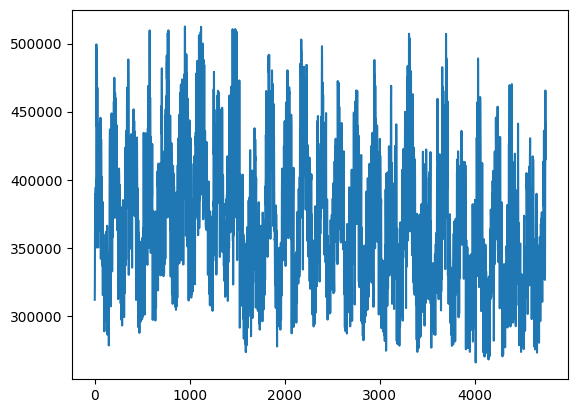

In [ ]:
plt.plot(df2)

# Normalisation de la cible

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df2_scaled = scaler.fit_transform(np.array(df2).reshape(-1, 1))
df2_scaled

array([[0.18659185],
       [0.23043834],
       [0.39757395],
       ...,
       [0.68252141],
       [0.60363827],
       [0.71066181]])

#Division des données en TrainSet et TestSet

In [ ]:
training_size = int(len(df2_scaled) * 0.65)
test_size = len(df2_scaled) - training_size
train_data, test_data = df2_scaled[0:training_size, :], df2_scaled[training_size:len(df2_scaled), :1]

#Création du dataset Pytorch

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
class EnergyDataset(Dataset):
    def __init__(self, data, seq_len=100):
        self.data = data
        self.data = torch.from_numpy(data).float().view(-1)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data)-self.seq_len-1

    def __getitem__(self, index):
        return self.data[index:index+self.seq_len], self.data[index+self.seq_len]


train_dataset = EnergyDataset(train_data)
test_dataset = EnergyDataset(test_data)

#Définition du bacth size & DataLoaders

In [ ]:
batch_size=64
train_dataloader = DataLoader(train_dataset, batch_size,drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size,drop_last=True)

#Utilisation du GPU pour un temps de traitement efficace et optimale
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Création du modèle

In [ ]:
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_size = input_dim
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hn, cn):
        out,(hn,cn) = self.lstm(x,(hn,cn))
        final_out = self.fc(out[-1])
        return final_out,hn,cn

    def predict(self, x):
        hn,cn = self.init()
        final_out = self.fc(out[-1])
        return final_out

    def init(self):
      h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
      c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
      return h0, c0

input_dim = 1
hidden_size = 50
num_layers = 3
output_size = 1

model = LSTMModel(input_dim, hidden_size, num_layers, output_size).to(device)

#Définition de la fonction perte

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Définition de la fontion d'entrainement

In [ ]:
def train(dataloader):
  hn, cn = model.init()
  model.train()
  for batch, item in enumerate(dataloader):
    x, y = item
    x = x.to(device)
    y = y.to(device)
    out, hn, cn = model(x.reshape(100, batch_size, 1),hn, cn)
    loss = loss_fn(out.reshape(batch_size), y)
    hn = hn.detach()
    cn = cn.detach()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch == len(dataloader)-1:
      loss = loss.item()
      print(f"train Loss: {loss:>7f}")


#Définition de la fontion de test

In [ ]:
def test(dataloader):
  hn, cn = model.init()
  model.eval()
  for batch, item in enumerate(dataloader):
    x, y = item
    x = x.to(device)
    y = y.to(device)
    out, hn, cn = model(x.reshape(100, batch_size, 1),hn, cn)
    loss = loss_fn(out.reshape(batch_size), y)

    if batch == len(dataloader)-1:
      loss = loss.item()
      print(f"test Loss: {loss:>7f}")

#Execution du modèle LSTM sur 35 époques

In [ ]:
epochs = 35
for epoch in range(epochs):
  print(f"Epoch: {epoch}")
  train(train_dataloader)
  test(test_dataloader)

Epoch: 0
train Loss: 0.004877
test Loss: 0.002663
Epoch: 1
train Loss: 0.005868
test Loss: 0.002685
Epoch: 2
train Loss: 0.005624
test Loss: 0.002546
Epoch: 3
train Loss: 0.005347
test Loss: 0.002810
Epoch: 4
train Loss: 0.004869
test Loss: 0.002578
Epoch: 5
train Loss: 0.005641
test Loss: 0.002671
Epoch: 6
train Loss: 0.005416
test Loss: 0.002515
Epoch: 7
train Loss: 0.005359
test Loss: 0.002748
Epoch: 8
train Loss: 0.004859
test Loss: 0.002519
Epoch: 9
train Loss: 0.005349
test Loss: 0.002684
Epoch: 10
train Loss: 0.005161
test Loss: 0.002491
Epoch: 11
train Loss: 0.005257
test Loss: 0.002697
Epoch: 12
train Loss: 0.004835
test Loss: 0.002470
Epoch: 13
train Loss: 0.005122
test Loss: 0.002666
Epoch: 14
train Loss: 0.005015
test Loss: 0.002449
Epoch: 15
train Loss: 0.005157
test Loss: 0.002617
Epoch: 16
train Loss: 0.004861
test Loss: 0.002414
Epoch: 17
train Loss: 0.004993
test Loss: 0.002586
Epoch: 18
train Loss: 0.004982
test Loss: 0.002388
Epoch: 19
train Loss: 0.005022
test Loss:

#Calcul de la métrique de validation MSE

In [ ]:
import math
from sklearn.metrics import mean_squared_error
def calculate_metrics(dataloader):
  predictions = []
  y_array = []
  with torch.no_grad():
    hn, cn = model.init()
    for batch, item in enumerate(dataloader):
      x, y = item
      x = x.to(device)
      y = y.to(device)
      x = x.view(100, batch_size, 1)
      pred = model(x, hn, cn)[0]
      pred = scaler.inverse_transform(pred.detach().cpu().numpy()).reshape(-1)
      y = scaler.inverse_transform(y.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
      predictions = predictions + pred.tolist()
      y_array = y_array + y.tolist()
    return math.sqrt(mean_squared_error(y_array, predictions)) , y_array, torch.tensor(predictions)




In [ ]:

print(f"train mse loss {calculate_metrics(train_dataloader)}")
print(f"test mse loss {calculate_metrics(test_dataloader)}")


train mse loss (18827.407881526524, [329595.0, 335568.0, 346691.03125, 347106.0, 338782.0, 309685.0, 296710.0, 338772.03125, 347358.0, 345837.03125, 336195.0, 339327.0, 336324.0, 352867.0, 360068.0, 351312.0, 348692.0, 351963.0, 345491.0, 314001.0, 300874.03125, 354829.03125, 361948.0, 356279.0, 348558.0, 338772.03125, 305282.0, 288499.0, 344112.0, 354265.0, 366216.0, 347610.0, 344416.0, 311363.0, 286320.0, 332366.0, 342444.0, 342162.0, 344802.0, 333687.0, 302452.0, 287690.0, 335285.0, 336577.0, 336957.0, 344745.0, 333854.0, 290557.0, 278378.0, 286890.0, 343505.0, 346510.0, 344445.03125, 346486.0, 340616.0, 356258.0, 415076.0, 420704.0, 428397.0, 434067.0, 436952.0, 384188.0, 364683.0, 421104.0, 428099.0, 388172.0, 361964.0, 349232.0, 314140.0, 307076.0, 365023.0, 383697.0, 401150.0, 402661.0, 420651.03125, 403889.0, 394028.0, 448727.0, 430341.0, 434576.03125, 427328.0, 404738.0, 339327.0, 332765.0, 362180.0, 389212.0, 388065.0, 374750.0, 375850.0, 357909.0, 358837.0, 415891.0, 444915.

#Evaluation du modèle

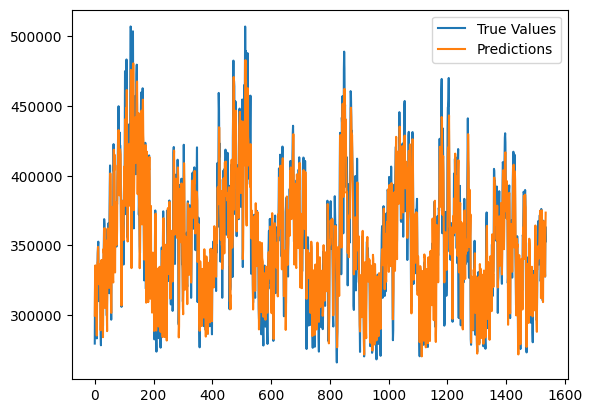

In [ ]:
mean_squared_error, y_test, test_outputs = calculate_metrics(test_dataloader)

plt.plot(y_test, label='True Values')
plt.plot(test_outputs.numpy(), label='Predictions')
plt.legend()
plt.show()

#Modèle N°2 : LSTM avec plus de features (Multivariate Time Series)

#Features Enginnering

### Features (1-7) -- Ajout de décalage temporelles (lags 1-7)

In [34]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

# Définir une fenêtre ordonnée par date
window_spec = Window.orderBy("date")

# Ajouter des lags (1 jour, 7 jours)
df1 = df1.withColumn("(consommation-1)", lag("Daily_Total_Consumption", 1).over(window_spec)) \
          .withColumn("(consommation-2)", lag("Daily_Total_Consumption", 2).over(window_spec)) \
          .withColumn("(consommation-3)", lag("Daily_Total_Consumption", 3).over(window_spec)) \
          .withColumn("(consommation-4)", lag("Daily_Total_Consumption", 4).over(window_spec)) \
          .withColumn("(consommation-5)", lag("Daily_Total_Consumption", 5).over(window_spec)) \
          .withColumn("(consommation-6)", lag("Daily_Total_Consumption", 6).over(window_spec)) \
          .withColumn("(consommation-7)", lag("Daily_Total_Consumption", 7).over(window_spec))

# Vérifier les données
df1.show()


+----------+-----------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+
|      Date|Daily_Total_Consumption|(consommation-1)|(consommation-2)|(consommation-3)|(consommation-4)|(consommation-5)|(consommation-6)|(consommation-7)|
+----------+-----------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+
|2005-01-01|               311897.0|            NULL|            NULL|            NULL|            NULL|            NULL|            NULL|            NULL|
|2005-01-02|               322712.0|        311897.0|            NULL|            NULL|            NULL|            NULL|            NULL|            NULL|
|2005-01-03|               363937.0|        322712.0|        311897.0|            NULL|            NULL|            NULL|            NULL|            NULL|
|2005-01-04|               374003.0|        363937.0|        322

###Feature 8 -- moyennes mobiles (fenêtres glissantes)
Cette variable a pour objectif de connaitre la moyenne de consommation des 7 derniers jours (max), cela pourra donner une information pertinente pour notre modèle

In [35]:
from pyspark.sql.functions import mean

# Fenêtre de 7 jours glissants (les 6 jours précédents + le jour actuel)
window_spec_7 = Window.orderBy("date").rowsBetween(-6, 0)

# Ajouter la moyenne mobile
df1 = df1.withColumn("moving_avg_7", mean("Daily_Total_Consumption").over(window_spec_7))

# Vérifier les données
df1.show()


+----------+-----------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+------------------+
|      Date|Daily_Total_Consumption|(consommation-1)|(consommation-2)|(consommation-3)|(consommation-4)|(consommation-5)|(consommation-6)|(consommation-7)|      moving_avg_7|
+----------+-----------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+------------------+
|2005-01-01|               311897.0|            NULL|            NULL|            NULL|            NULL|            NULL|            NULL|            NULL|          311897.0|
|2005-01-02|               322712.0|        311897.0|            NULL|            NULL|            NULL|            NULL|            NULL|            NULL|          317304.5|
|2005-01-03|               363937.0|        322712.0|        311897.0|            NULL|            NULL|            NULL|    

###Extraction des variables (Feature 9 -- Jour) (Feature 10 mois) (Feature 11 -- saison)

In [36]:
from pyspark.sql.functions import dayofweek, month, when

# Extraire jour de la semaine et mois
df1 = df1.withColumn("day_of_week", dayofweek("date")) \
       .withColumn("month", month("date"))

# Ajouter une colonne pour la saison
#df1 = df1.withColumn("season", when((month("date") >= 3) & (month("date") <= 5), "printemps")
#                           .when((month("date") >= 6) & (month("date") <= 8), "été")
 #                          .when((month("date") >= 9) & (month("date") <= 11), "automne")
  #                         .otherwise("hiver"))

# Vérifier les nouvelles colonnes
df1.show()


+----------+-----------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+------------------+-----------+-----+
|      Date|Daily_Total_Consumption|(consommation-1)|(consommation-2)|(consommation-3)|(consommation-4)|(consommation-5)|(consommation-6)|(consommation-7)|      moving_avg_7|day_of_week|month|
+----------+-----------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+------------------+-----------+-----+
|2005-01-01|               311897.0|            NULL|            NULL|            NULL|            NULL|            NULL|            NULL|            NULL|          311897.0|          7|    1|
|2005-01-02|               322712.0|        311897.0|            NULL|            NULL|            NULL|            NULL|            NULL|            NULL|          317304.5|          1|    1|
|2005-01-03|               363937.0

###Elimination des NAN résultantes de l'extraction de features

In [37]:
# Filtrer les valeurs nulles introduites par les lags
df1 = df1.dropna()

# Vérifier les données finales
df1.show()


+----------+-----------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+------------------+-----------+-----+
|      Date|Daily_Total_Consumption|(consommation-1)|(consommation-2)|(consommation-3)|(consommation-4)|(consommation-5)|(consommation-6)|(consommation-7)|      moving_avg_7|day_of_week|month|
+----------+-----------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+------------------+-----------+-----+
|2005-01-08|               363338.0|        389679.0|        374851.0|        389445.0|        374003.0|        363937.0|        322712.0|        311897.0|368280.71428571426|          7|    1|
|2005-01-09|               349828.0|        363338.0|        389679.0|        374851.0|        389445.0|        374003.0|        363937.0|        322712.0| 372154.4285714286|          1|    1|
|2005-01-10|               390332.0

In [ ]:
df3 = df1.drop('Date').toPandas()
df3.reset_index(drop=True, inplace=True)
features = df3.drop(columns=['Daily_Total_Consumption'])
target = df3['Daily_Total_Consumption']
df3

,Daily_Total_Consumption,(consommation-1),(consommation-2),(consommation-3),(consommation-4),(consommation-5),(consommation-6),(consommation-7),moving_avg_7,day_of_week,month
0,363338.0,389679.0,374851.0,389445.0,374003.0,363937.0,322712.0,311897.0,368280.714286,7,1
1,349828.0,363338.0,389679.0,374851.0,389445.0,374003.0,363937.0,322712.0,372154.428571,1,1
2,390332.0,349828.0,363338.0,389679.0,374851.0,389445.0,374003.0,363937.0,375925.142857,2,1
3,394250.0,390332.0,349828.0,363338.0,389679.0,374851.0,389445.0,374003.0,378817.571429,3,1
4,368065.0,394250.0,390332.0,349828.0,363338.0,389679.0,374851.0,389445.0,375763.285714,4,1
...,...,...,...,...,...,...,...,...,...,...,...
4736,439663.0,400713.0,362107.0,330255.0,326509.0,350410.0,380985.0,362297.0,370091.714286,4,12
4737,465511.0,439663.0,400713.0,362107.0,330255.0,326509.0,350410.0,380985.0,382166.857143,5,12
4738,434221.0,465511.0,439663.0,400713.0,362107.0,330255.0,326509.0,350410.0,394139.857143,6,12
4739,414764.0,434221.0,465511.0,439663.0,400713.0,362107.0,330255.0,326509.0,406747.714286,7,12


In [ ]:
target

,Daily_Total_Consumption
0,363338.0
1,349828.0
2,390332.0
3,394250.0
4,368065.0
...,...
4736,439663.0
4737,465511.0
4738,434221.0
4739,414764.0


#Normalisation pour le modèle N°2 de LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

In [ ]:
features_scaled

array([[0.50193792, 0.44182181, 0.50098923, ..., 0.36951808, 1.        ,
        0.        ],
       [0.39514547, 0.50193792, 0.44182181, ..., 0.39019987, 0.        ,
        0.        ],
       [0.34037283, 0.39514547, 0.50193792, ..., 0.41033174, 0.16666667,
        0.        ],
       ...,
       [0.80937824, 0.70458452, 0.54667229, ..., 0.50758025, 0.83333333,
        1.        ],
       [0.68252141, 0.80937824, 0.70458452, ..., 0.5748937 , 1.        ,
        1.        ],
       [0.60363827, 0.68252141, 0.80937824, ..., 0.65948418, 0.        ,
        1.        ]])

# split

In [ ]:
training_size = int(len(features_scaled) * 0.65)
test_size = len(features_scaled) - training_size

X_train, y_train = features_scaled[0:training_size, :], target_scaled[0:training_size, :]
X_test, y_test = features_scaled[training_size:len(features_scaled), :], target_scaled[training_size:len(features_scaled), :]


In [ ]:
X_test.shape

(1660, 10)

In [ ]:
# Create sequences
def create_sequences(features, target, sequence_length):
    sequences = []
    labels = []
    for i in range(len(features) - sequence_length):
        seq = features[i:i + sequence_length]
        label = target[i + sequence_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [ ]:
train_sequences, train_labels = create_sequences(X_train, y_train, sequence_length=100)
test_sequences, test_labels = create_sequences(X_test, y_test, sequence_length=100)

In [ ]:
test_labels.shape

(1560, 1)

In [ ]:
import torch
from torch.utils.data import Dataset

class EnergyTSDataset(Dataset):
    def __init__(self, sequences, labels):
        """
        Args:
            sequences (np.array): Input sequences (features).
            labels (np.array): Corresponding labels (targets).
        """
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        # Return the total number of samples
        return len(self.sequences)

    def __getitem__(self, idx):
        # Return the sequence and label at index `idx`
        return self.sequences[idx], self.labels[idx]

In [ ]:
# Create PyTorch datasets
train_dataset = EnergyTSDataset(train_sequences, train_labels)
test_dataset = EnergyTSDataset(test_sequences, test_labels)

In [ ]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 64

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
for sequences, labels in test_loader:
    print("Batch of sequences:", sequences.shape)
    print("Batch of labels:", labels.shape)
    # Use `sequences` and `labels` in your model


Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batch of sequences: torch.Size([64, 100, 10])
Batch of labels: torch.Size([64, 1])
Batc

In [ ]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Cell state
        out, _ = self.lstm(x, (h0, c0))  # LSTM output
        out = self.fc(out[:, -1, :])  # Fully connected layer (using the last time step)
        return out

In [ ]:
# Hyperparameters
input_size = 10  # Number of features
hidden_size = 64  # Number of hidden units in the LSTM
output_size = 1  # Single output value (e.g., regression)
num_layers = 1
learning_rate = 0.001

model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()  # Assuming this is a regression task
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20  # Number of epochs to train

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0

    for sequences, labels in train_loader:  # Iterate over training batches
        sequences, labels = sequences.to(device), labels.to(device)

        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Print epoch loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")


Epoch [1/20], Loss: 0.0351
Epoch [2/20], Loss: 0.0190
Epoch [3/20], Loss: 0.0174
Epoch [4/20], Loss: 0.0158
Epoch [5/20], Loss: 0.0143
Epoch [6/20], Loss: 0.0130
Epoch [7/20], Loss: 0.0124
Epoch [8/20], Loss: 0.0118
Epoch [9/20], Loss: 0.0115
Epoch [10/20], Loss: 0.0112
Epoch [11/20], Loss: 0.0110
Epoch [12/20], Loss: 0.0109
Epoch [13/20], Loss: 0.0106
Epoch [14/20], Loss: 0.0107
Epoch [15/20], Loss: 0.0105
Epoch [16/20], Loss: 0.0105
Epoch [17/20], Loss: 0.0106
Epoch [18/20], Loss: 0.0105
Epoch [19/20], Loss: 0.0104
Epoch [20/20], Loss: 0.0102


In [ ]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    test_loss = 0
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        #print(sequences.shape)
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

    print(f"Test Loss: {test_loss/len(test_loader):.4f}")

Test Loss: 0.0122


#Modèle Avec SPARK (Regression)

In [42]:
df4 = df1
df4.show()

+----------+-----------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+------------------+-----------+-----+
|      Date|Daily_Total_Consumption|(consommation-1)|(consommation-2)|(consommation-3)|(consommation-4)|(consommation-5)|(consommation-6)|(consommation-7)|      moving_avg_7|day_of_week|month|
+----------+-----------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+------------------+-----------+-----+
|2005-01-08|               363338.0|        389679.0|        374851.0|        389445.0|        374003.0|        363937.0|        322712.0|        311897.0|368280.71428571426|          7|    1|
|2005-01-09|               349828.0|        363338.0|        389679.0|        374851.0|        389445.0|        374003.0|        363937.0|        322712.0| 372154.4285714286|          1|    1|
|2005-01-10|               390332.0

In [43]:
# Diviser les données
train_data, test_data = df4.randomSplit([0.8, 0.2], seed=42)

###Normalisation avec Spark

In [44]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline

features_columns=["(consommation-1)", "(consommation-2)", "(consommation-3)", "(consommation-4)", "(consommation-5)", "(consommation-6)", "(consommation-7)", "moving_avg_7", "day_of_week", "month"]
assembler = VectorAssembler(inputCols=features_columns, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

pipeline = Pipeline(stages=[assembler, scaler])

train_data = pipeline.fit(train_data).transform(train_data)
test_data = pipeline.fit(test_data).transform(test_data)



In [50]:
test_data.select("scaled_features").show()


+--------------------+
|     scaled_features|
+--------------------+
|[0.32547424349342...|
|[0.37027105558092...|
|[0.52349425096509...|
|[0.73497986800049...|
|[0.63190818147856...|
|[0.47606159976754...|
|[0.42124029720642...|
|[0.70708563363911...|
|[0.46004316964841...|
|[0.47896724918019...|
|[0.49831472334066...|
|[0.59607737329293...|
|[0.39281889502303...|
|[0.67862687310613...|
|[0.62354406209787...|
|[0.51192561537503...|
|[0.34768170686148...|
|[0.10498526420655...|
|[0.30747166991822...|
|[0.37578348760948...|
+--------------------+
only showing top 20 rows



In [52]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

LinearRegression = LinearRegression(featuresCol="scaled_features", labelCol="Daily_Total_Consumption", predictionCol="prediction")

model = LinearRegression.fit(train_data)

predictions = model.transform(test_data)

In [53]:
from pyspark.ml.evaluation import RegressionEvaluator

# Initialiser l'évaluateur
evaluator = RegressionEvaluator(labelCol="Daily_Total_Consumption", predictionCol="prediction", metricName="rmse")

# Calculer le RMSE
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) : {rmse}")


Root Mean Squared Error (RMSE) : 5663.57077110896


In [54]:
# Sélectionner les colonnes nécessaires
predicted_data = predictions.select("Daily_Total_Consumption", "prediction")

# Afficher les données
predicted_data.show()



+-----------------------+------------------+
|Daily_Total_Consumption|        prediction|
+-----------------------+------------------+
|               390332.0| 392917.6207188676|
|               400007.0|  403411.763822624|
|               400928.0| 404031.6756682272|
|               453776.0|448268.01480477734|
|               457276.0| 450801.9262968364|
|               427070.0| 422674.7772719565|
|               350214.0| 348008.3295289194|
|               373987.0|375668.07260646904|
|               386806.0| 386744.4188269995|
|               391467.0|  392313.728037716|
|               420623.0| 422412.7186444538|
|               375256.0| 376658.0956550334|
|               410460.0| 410996.8073623723|
|               423921.0| 423299.9400953255|
|               408397.0| 410218.0581213772|
|               379773.0| 381553.3943690293|
|               328211.0|  330884.734477096|
|               338772.0| 346036.6785520438|
|               314001.0| 319035.8920327135|
|         

In [55]:
# Convertir le Spark DataFrame en Pandas DataFrame
predicted_data_pd = predicted_data.toPandas()


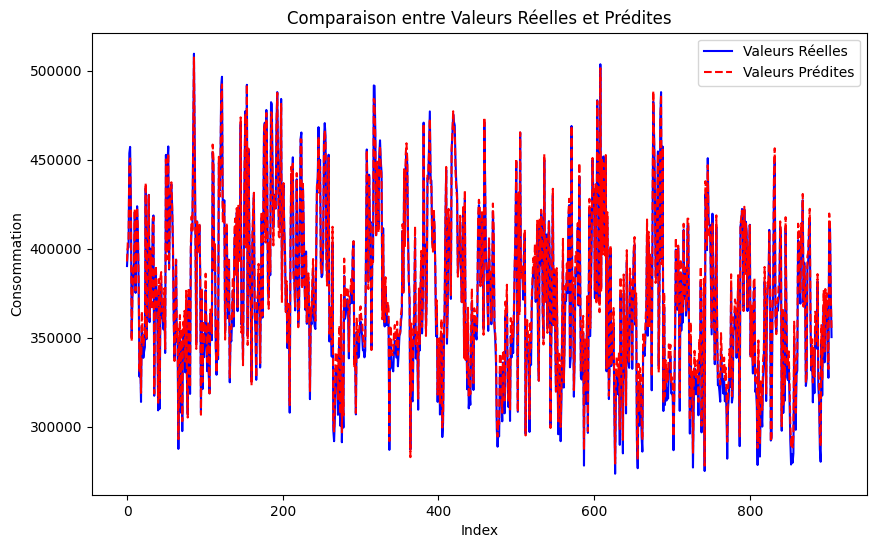

In [56]:
import matplotlib.pyplot as plt

# Tracer les valeurs réelles et prédites
plt.figure(figsize=(10, 6))
plt.plot(predicted_data_pd["Daily_Total_Consumption"], label="Valeurs Réelles", color="blue")
plt.plot(predicted_data_pd["prediction"], label="Valeurs Prédites", color="red", linestyle="dashed")

# Ajouter des légendes et des titres
plt.title("Comparaison entre Valeurs Réelles et Prédites")
plt.xlabel("Index")
plt.ylabel("Consommation")
plt.legend()
plt.show()


#Visualisation de l'erreur résiduelle

In [58]:
residuals = predictions.withColumn("residual", predictions["Daily_Total_Consumption"] - predictions["prediction"])


In [59]:
residuals.describe("residual").show()

+-------+-------------------+
|summary|           residual|
+-------+-------------------+
|  count|                906|
|   mean|-3469.4939826857576|
| stddev|  4478.927051545056|
|    min|-12114.033630200545|
|    max| 10524.191112412256|
+-------+-------------------+



In [61]:
residuals_pd = residuals.select("residual").toPandas()
residuals_pd.head()

,residual
0,-2585.620719
1,-3404.763823
2,-3103.675668
3,5507.985195
4,6474.073703


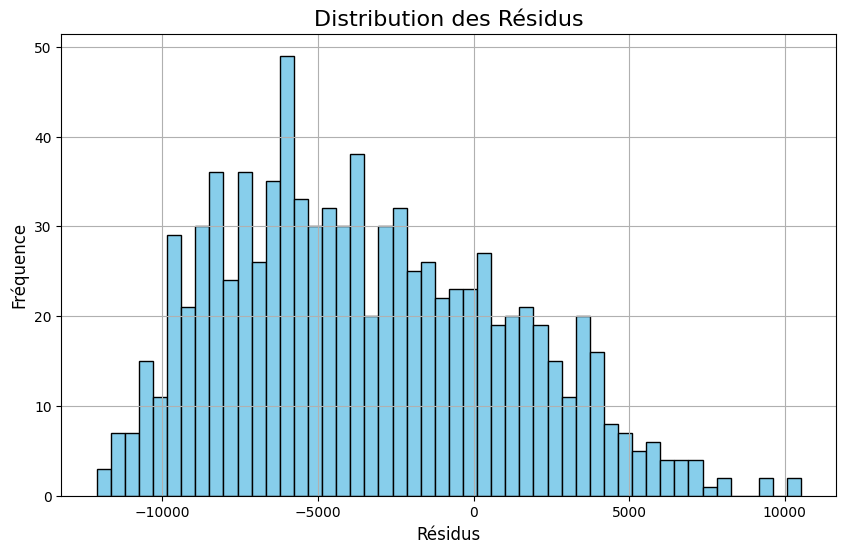

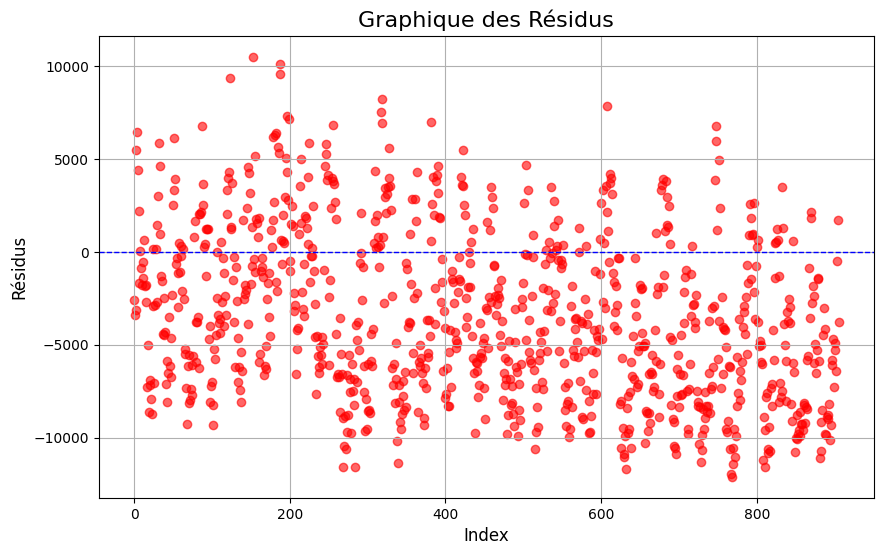

In [62]:
import matplotlib.pyplot as plt

# Histogramme des résidus
plt.figure(figsize=(10, 6))
plt.hist(residuals_pd["residual"], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution des Résidus", fontsize=16)
plt.xlabel("Résidus", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.grid(True)
plt.show()

# Graphique de dispersion des résidus
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals_pd)), residuals_pd["residual"], alpha=0.6, color="red")
plt.axhline(y=0, color="blue", linestyle="--", linewidth=1)
plt.title("Graphique des Résidus", fontsize=16)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Résidus", fontsize=12)
plt.grid(True)
plt.show()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Créez une session Spark
spark = SparkSession.builder.appName("TimeSeriesPrediction").getOrCreate()

# Charger les données
data = [
    (1, 100.0), (2, 101.5), (3, 102.3), (4, 103.8), (5, 105.2),
    (6, 106.5), (7, 108.1), (8, 109.3), (9, 110.7), (10, 112.0)
]
columns = ["Time", "Value"]

df = spark.createDataFrame(data, columns)

# Assembler les caractéristiques
assembler = VectorAssembler(inputCols=["Time"], outputCol="features")
df = assembler.transform(df)

# Diviser les données en ensemble d'entraînement et de test
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)

# Créer un modèle de régression linéaire
lr = LinearRegression(featuresCol="features", labelCol="Value")

# Entraîner le modèle
lr_model = lr.fit(train_data)

# Faire des prédictions
predictions = lr_model.transform(test_data)

# Afficher les prédictions
predictions.select("Time", "Value", "prediction").show()

# Fermer la session Spark
spark.stop()


In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# 1. Indexer la colonne catégorielle 'season'
indexer = StringIndexer(inputCol="season", outputCol="season_index")
df1 = indexer.fit(df1).transform(df1)

# 2. Appliquer le OneHotEncoder pour 'season_index'
encoder = OneHotEncoder(inputCols=["season_index"], outputCols=["season_encoded"] ,handleInvalid="keep")
df1 = encoder.fit(df1).transform(df1)

# 3. Vérifier les nouvelles colonnes
df1.select("season", "season_index", "season_encoded").show()


+------+------------+--------------+
|season|season_index|season_encoded|
+------+------------+--------------+
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
| hiver|         3.0| (4,[3],[1.0])|
+------+------------+--------------+
only showing top 20 rows



In [ ]:
df1 = df1.drop("season", "season_index")
df1.show()

+----------+-----------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+------------------+-----------+-----+--------------+
|      Date|Daily_Total_Consumption|(consommation-1)|(consommation-2)|(consommation-3)|(consommation-4)|(consommation-5)|(consommation-6)|(consommation-7)|      moving_avg_7|day_of_week|month|season_encoded|
+----------+-----------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+------------------+-----------+-----+--------------+
|2005-01-08|               363338.0|        389679.0|        374851.0|        389445.0|        374003.0|        363937.0|        322712.0|        311897.0|368280.71428571426|          7|    1| (4,[3],[1.0])|
|2005-01-09|               349828.0|        363338.0|        389679.0|        374851.0|        389445.0|        374003.0|        363937.0|        322712.0| 372154.42857

# Séparation de la "target" des "features"

In [ ]:
features_unscaled = df1.drop("Date","Daily_Total_Consumption")
target = df1.select("Daily_Total_Consumption")
target.show()

+-----------------------+
|Daily_Total_Consumption|
+-----------------------+
|               363338.0|
|               349828.0|
|               390332.0|
|               394250.0|
|               368065.0|
|               360620.0|
|               400007.0|
|               397533.0|
|               400928.0|
|               480699.0|
|               499350.0|
|               477819.0|
|               448482.0|
|               453776.0|
|               439113.0|
|               462987.0|
|               495527.0|
|               440343.0|
|               423651.0|
|               457276.0|
+-----------------------+
only showing top 20 rows



In [ ]:
features_unscaled.show()

+----------------+----------------+----------------+----------------+----------------+----------------+----------------+
|(consommation-1)|(consommation-2)|(consommation-3)|(consommation-4)|(consommation-5)|(consommation-6)|(consommation-7)|
+----------------+----------------+----------------+----------------+----------------+----------------+----------------+
|        389679.0|        374851.0|        389445.0|        374003.0|        363937.0|        322712.0|        311897.0|
|        363338.0|        389679.0|        374851.0|        389445.0|        374003.0|        363937.0|        322712.0|
|        349828.0|        363338.0|        389679.0|        374851.0|        389445.0|        374003.0|        363937.0|
|        390332.0|        349828.0|        363338.0|        389679.0|        374851.0|        389445.0|        374003.0|
|        394250.0|        390332.0|        349828.0|        363338.0|        389679.0|        374851.0|        389445.0|
|        368065.0|        394250

###Normalisation des données

In [ ]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.sql.functions import array


#assembler = VectorAssembler(
 #   inputCols=["(consommation-1)", "(consommation-2)", "(consommation-3)", "(consommation-4)", "(consommation-5)", "(consommation-6)", "(consommation-7)", "moving_avg_7", "day_of_week", "month"],
  #  outputCol="features"
#)

assembler_features = VectorAssembler(
    inputCols=["(consommation-1)", "(consommation-2)", "(consommation-3)", "(consommation-4)", "(consommation-5)", "(consommation-6)", "(consommation-7)"],
    outputCol="features"
)
features_assembled = assembler_features.transform(features_unscaled)

#Assemble Target
assembler_target = VectorAssembler(inputCols=["Daily_Total_Consumption"], outputCol="Daily_Total_Consumption_vector")
target_assembled = assembler_target.transform(target)


# Normaliser les features
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
scaler_model_features= scaler.fit(features_assembled)
df_features = scaler_model_features.transform(features_assembled)

#Normaliser la cible
scaler1 = MinMaxScaler(inputCol="Daily_Total_Consumption_vector", outputCol="target_scaled")
scaler_model_target = scaler1.fit(target_assembled)
df_target = scaler_model_target.transform(target_assembled)


#Normalisation2

In [ ]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

# 1. Assembler les features
assembler_features = VectorAssembler(
    inputCols=["Daily_Total_Consumption", "(consommation-1)", "(consommation-2)",
               "(consommation-3)", "(consommation-4)", "(consommation-5)",
               "(consommation-6)", "(consommation-7)"],
    outputCol="features"
)
features_assembled = assembler_features.transform(features_unscaled)

# 2. Normaliser les features
scaler_features = MinMaxScaler(inputCol="features", outputCol="features_scaled")
scaler_features_model = scaler_features.fit(features_assembled)
df_normalized = scaler_features_model.transform(features_assembled)

# 3. Normaliser la target
assembler_target = VectorAssembler(inputCols=["Daily_Total_Consumption"], outputCol="target_vector")
df_with_target = assembler_target.transform(df_normalized)

scaler_target = MinMaxScaler(inputCol="target_vector", outputCol="target_scaled")
scaler_target_model = scaler_target.fit(df_with_target)
df_final = scaler_target_model.transform(df_with_target)

# 4. Séparer les données normalisées
# Features normalisées
X = df_final.select("features_scaled").rdd.map(lambda row: row[0]).collect()
# Target normalisée
y = df_final.select("target_scaled").rdd.map(lambda row: row[0][0]).collect()


In [ ]:
df_features.printSchema()
print("Number of columns in features_unscaled:", len(df_features.columns))

root
 |-- (consommation-1): double (nullable = true)
 |-- (consommation-2): double (nullable = true)
 |-- (consommation-3): double (nullable = true)
 |-- (consommation-4): double (nullable = true)
 |-- (consommation-5): double (nullable = true)
 |-- (consommation-6): double (nullable = true)
 |-- (consommation-7): double (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_scaled: vector (nullable = true)

Number of columns in features_unscaled: 9


In [ ]:
df_target.show()

+-----------------------+------------------------------+--------------------+
|Daily_Total_Consumption|Daily_Total_Consumption_vector|       target_scaled|
+-----------------------+------------------------------+--------------------+
|               363338.0|                    [363338.0]|[0.39514546574987...|
|               349828.0|                    [349828.0]|[0.34037282693305...|
|               390332.0|                    [390332.0]|[0.5045853334198236]|
|               394250.0|                    [394250.0]|[0.5204698040996367]|
|               368065.0|                    [368065.0]|[0.4143098079916969]|
|               360620.0|                    [360620.0]|[0.3841260703165542]|
|               400007.0|                    [400007.0]|[0.5438100025947068]|
|               397533.0|                    [397533.0]|[0.5337798391281785]|
|               400928.0|                    [400928.0]|[0.5475439478463934]|
|               480699.0|                    [480699.0]|[0.87095

###Construction du dataframe final après normalisation

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

features_scaled = df_features.select("features_scaled")
Daily_Total_Consumption = df_target.select("target_scaled")

features_scaled = features_scaled.withColumn("index", monotonically_increasing_id())
Daily_Total_Consumption = Daily_Total_Consumption.withColumn("index", monotonically_increasing_id())

##Split des données d'entrainement (TrainSet) et de test (TestSet)

##Création des séquence pour entrainer le modèle LSTM